_____________________
<h3><b>8. Convolutional neural network</b></h3>

___________________

In [1]:
#import libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import tensorflow as tf #tf version is 1.12
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
import tensorflow.keras as keras
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

Here I don't use the extracted high-level features but a ConvNet created from scratch and using the pixel values from the original images.

I will use generators to create my model. Different from the initial preprocessing, here I will use data augmentation attempting to hopefully obtain good results and avoid overfitting.

In [2]:
#create generators
#train
generator_cnn = ImageDataGenerator(rescale=1/255, 
                                   dtype=np.float32,
                                   width_shift_range=0.2, #randomly translate pictures vertically or horizontally (0.2=fraction of the total image)
                                   height_shift_range=0.2, 
                                   shear_range=0.2, #displaces each point in a fixed direction
                                   rotation_range=90, #range within which to randomly rotate pictures
                                   zoom_range=0.2, #zoom in 
                                   horizontal_flip=True,
                                   fill_mode='nearest') #how to fill the newly created pixels
#valid/test
generator_val_test = ImageDataGenerator(rescale=1/255, dtype=np.float32)

In [3]:
#apply generator to train, valid and test data
trainset = generator_cnn.flow_from_directory(
    os.path.join('train'), batch_size=32, target_size=(256, 256), color_mode='rgb',
    interpolation='bilinear',#bilinear is the default but better to outline it
    shuffle = True)

validset = generator_val_test.flow_from_directory(
    os.path.join('valid'), batch_size=32, target_size=(256, 256), color_mode='rgb',
    interpolation='bilinear',#bilinear is the default but better to outline it
    shuffle = False)

testset = generator_val_test.flow_from_directory(
    os.path.join('test'), batch_size=32, target_size=(256, 256), color_mode='rgb',
    interpolation='bilinear',#bilinear is the default but better to outline it
    shuffle = False)

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [4]:
#define the network
import tensorflow.keras as keras

# Convolutional Network
model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='same', #same = zero padding 
                                  activation='relu', input_shape=(256, 256, 3)))
model_cnn.add(keras.layers.MaxPool2D(pool_size=2))
model_cnn.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='same', #same = zero padding 
                                  kernel_regularizer=regularizers.l2(0.01),
                                  activation='relu'))
#model.add(Dense(32, activation='relu'))
model_cnn.add(keras.layers.MaxPool2D(pool_size=2))
model_cnn.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same',
                                  activation='relu'))
model_cnn.add(keras.layers.MaxPool2D(pool_size=2))
model_cnn.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,
                                  activation='relu'))
model_cnn.add(keras.layers.MaxPool2D(pool_size=2))
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(units=trainset.num_classes, activation='softmax'))

#print model
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 64)        36928     
__________

In [5]:
# create an early_stopping callback to stop the training once the loss doesn't improve for 10 epochs
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [6]:
#compile the model
model_cnn.compile(optimizer=keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['acc'])

In [7]:
#train the model
history_cnn = model_cnn.fit_generator(generator=trainset,
                                      validation_data=validset,
                                      callbacks=[early_stopping],
                                      verbose=0,#turn off the epochs printing to not overload the notebook
                                      epochs=100)
#note: the results change over each run unless PYTHONHASHSEED and all the modules seeds are specified and here are NOT.

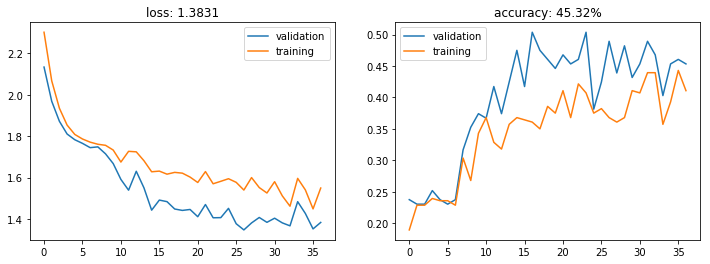

In [8]:
#plot training curves
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title('loss: {:.4f}'.format(history_cnn.history['val_loss'][-1]))
ax1.plot(history_cnn.history['val_loss'], label='validation')
ax1.plot(history_cnn.history['loss'], label='training')
ax1.legend()

# plot accuracy values
ax2.set_title('accuracy: {:.2f}%'.format(history_cnn.history['val_acc'][-1]*100))
ax2.plot(history_cnn.history['val_acc'], label='validation')
ax2.plot(history_cnn.history['acc'], label='training')
ax2.legend()

plt.show()

In [9]:
#test predictions
test_preds_cnn = model_cnn.predict_generator(testset)#return an array (50,6)

#confusion matrix
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
matrix = confusion_matrix(
    y_true=testset.classes, # array with true labels
    y_pred=test_preds_cnn.argmax(axis=1) # array with predicted labels
)

# Format as a DataFrame
class_names = list(testset.class_indices.keys())
matrix_df = pd.DataFrame(data=matrix, columns=class_names, index=class_names)
matrix_df.columns.name = 'Predictions'
matrix_df.index.name = 'True class'

#display the df as heatmap to ease the visualization
matrix_df.style.background_gradient(cmap ='viridis', axis=1)

Predictions,bike,car,motorcycle,other,truck,van
True class,,,,,,
bike,10,0,1,0,1,0
car,2,7,1,0,1,0
motorcycle,3,5,1,0,0,0
other,2,1,0,0,3,0
truck,2,1,0,0,4,0
van,1,3,0,0,1,0


In [10]:
#evaluate on test data
test_loss, test_acurracy_cnn = model_cnn.evaluate_generator(testset)
print('Test loss: {:.2f}'.format(test_loss))
print('accuracy CNN: {:.2f}%'.format(test_acurracy_cnn))

Test loss: 1.47
accuracy CNN: 0.44%


I cannot achieve good results (the accuracy suggests that the images are classified at the chance). After trying different combinations of parameters (not reported here) I believe that despite everything, the amount of data is insufficient to properly train a model with good accuracy (around 70%). Furthermore, the classes are quite imbalanced.

In [11]:
#store the accuracy in a df

models_summary = {'model': ['cnn'],
                  'test_accuracy': [test_acurracy_cnn]}
models_summary = pd.DataFrame(models_summary)
models_summary.to_csv("models_summary.csv", mode='a', index=False, header=False)#append to models_summary